In [0]:
!pip install geopandas rasterio scikit-image

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-3eca651f-58dc-4513-966a-3bab88e304da/bin/python -m pip install --upgrade pip' command.


In [0]:
from datetime import date, timedelta
import requests
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import time
import os
import re
from skimage.transform import resize
import rasterio
from rasterio.mask import mask
from shapely import wkt
import matplotlib.pyplot as plt

In [0]:
# A function to obtain a token for future API calls
def get_keycloak(username: str, password: str) -> str:
    data = {
        "client_id": "cdse-public",
        "username": username,
        "password": password,
        "grant_type": "password",
    }
    try:
        r = requests.post(
            "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token",
            data=data,
        )
        r.raise_for_status()
    except Exception as e:
        raise Exception(
            f"Keycloak token creation failed. Reponse from the server was: {r.json()}"
        )
    return r.json()["access_token"]


# An API call to get download info
def fetch_copernicus_data(data_collection, ft, date_start_string, date_end_string):
    url = f"https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=Collection/Name eq '{data_collection}' and OData.CSC.Intersects(area=geography'SRID=4326;{ft}') and ContentDate/Start gt {date_start_string}T00:00:00.000Z and ContentDate/Start lt {date_end_string}T00:00:00.000Z&$expand=Assets&$top=1000"

    response = requests.get(url)
    return response.json()

In [0]:
# A function to diagnose the API requests by printing status and downloaded items
def diagnoseRequest(response) :
    print("------------------------")
    print("Request Diagnostic: ")
    print(f"request code: {response.status_code}")
    print(f"request reason: {response.reason}")
    print("Response Headers:")
    for key, value in response.headers.items():
        print(f"{key}: {value}")
    print("------------------------")

# A function that verifies that paths exist and contain files
def verify_files(files_paths):
    """
    Verify if the files have been written correctly.

    Parameters:
    - files_paths: dict, mapping of file names to their download paths

    Returns:
    - results: dict, mapping of file names to their verification status
    """
    results = {}
    for name, path in files_paths.items():
        # Verify if the file has been written correctly
        if os.path.exists(path) and os.path.getsize(path) > 0:
            print(f"{name} ")
            print("File has been successfully written")
            results[name] = "Success"
        else:
            print("Error while writing the file")
            results[name] = "Error"
    return results

In [0]:
def process_copernicus_data(json_data, tiles, copernicus_user, copernicus_pwd, diagnostic=False):
    """
    Process the data from Copernicus response and download the relevant files.

    Parameters:
    - json_data: dict, the JSON response from Copernicus API
    - tiles: list, list of tile names to filter the products
    - copernicus_user: str, Copernicus API username
    - copernicus_pwd: str, Copernicus API password
    - diagnostic: bool, flag to print diagnostic information

    Returns:
    - files_paths: dict, mapping of file names to their download paths
    """
    # Extract values from the response
    p = pd.DataFrame.from_dict(json_data["value"])

    if p.shape[0] > 0:  # If the request returned some products
        # Create a geometry field
        p["geometry"] = p["GeoFootprint"].apply(shape)
        
        # Convert PD to GPD
        product_df = gpd.GeoDataFrame(p).set_geometry("geometry")

        # Only keep L2A products for the selected tiles
        product_df = product_df[product_df["Name"].str.contains('L2A.*(' + '|'.join(tiles) + ')')]

        print(f"Total tiles found: {len(product_df)}")

        # Extract the identifier column as the first part of the name
        product_df["identifier"] = product_df["Name"].str.split(".").str[0]
        all_feat = len(product_df)

        if all_feat == 0:
            print("No tiles found for the selected date")
        else:
            files_paths = {}
            # Download all tiles from server iterating on each feature
            for index, feat in enumerate(product_df.iterfeatures()):
                try:
                    session = requests.Session()
                    keycloak_token = get_keycloak(copernicus_user, copernicus_pwd)
                    session.headers.update({"Authorization": f"Bearer {keycloak_token}"})
                    url = f"https://catalogue.dataspace.copernicus.eu/odata/v1/Products({feat['properties']['Id']})/$value"
                    response = session.get(url, allow_redirects=False)

                    if diagnostic:
                        print("Request 1 Diagnostic:")
                        diagnose_request(response)

                    # If files have been moved, update URL and repeat the request
                    while response.status_code in (301, 302, 303, 307):
                        url = response.headers["Location"]
                        response = session.get(url, allow_redirects=False)
                        if diagnostic:
                            print("------------------------")
                            print("Request 2 Diagnostic: ")
                            diagnose_request(response)

                    print(feat["properties"]["Id"])
                    print("Send GET request")

                    time_start = time.time()
                    file = session.get(url, verify=True, allow_redirects=True)
                    time_end = time.time()
                    duration = time_end - time_start
                    # Diagnostic
                    if diagnostic:
                        print("------------------------")
                        print("Request 3 Diagnostic: ")
                        print(f"Duration of the GET request: {duration}")
                        diagnose_request(file)

                    # Save the file
                    with open(
                        f"{feat['properties']['identifier']}.zip",  # Location to save zip from Copernicus
                        "wb",
                    ) as p:
                        print("File location: " + f"{feat['properties']['identifier']}.zip")
                        print("File name: " + feat["properties"]["Name"])
                        p.write(file.content)

                        files_paths[feat["properties"]["Name"]] = f"{feat['properties']['identifier']}.zip"
                
                except Exception as e:
                    print("Problem with server:", e)
            session.close()
            return files_paths
    else:
        print('No data found')
        return None


In [0]:
def zip_to_ndvi_np(file_path: str, destination_path: str, show_bands = False):
    import zipfile
    import os
    import re
    import rasterio
    from rasterio.plot import show
    # used to convert raster data into float(32)
    import numpy as np
    import matplotlib.pyplot as plt

    # Define pattern to only extract B04 and B08 at 10m resolution
    pattern_bands = re.compile('.*B0[48]_10m.jp2')
    # I want to extract the tile code, so what's between T32 and an underscore
    pattern_tile = re.compile('T32.{3}?_')
    # Extract files from zip
    with zipfile.ZipFile(file_path, 'r') as zip_ref:
        # List files that match regex criteria (bands 04 and 08)
        file_list = [e for e in zip_ref.namelist() if pattern_bands.search(e)]
        # Extract Tile's code
        tile = pattern_tile.findall(file_path)[0][3:6]
        
        # Create the directory if not existent
        if not os.path.exists(destination_path):
            os.makedirs(destination_path)
        
        # Extract selected bands
        for file in file_list:
            zip_ref.extract(file, destination_path)
            print(f"Extracted: {file}")

    # Final paths for extracted bands
    b04_path = [os.path.join(destination_path, file) for file in file_list if 'B04' in file][0]
    b08_path = [os.path.join(destination_path, file) for file in file_list if 'B08' in file][0]

    # Open + show files using rasterio
    with rasterio.open(b04_path) as b04_src, rasterio.open(b08_path) as b08_src:
        b04 = b04_src.read(1).astype('float32')
        b08 = b08_src.read(1).astype('float32')
        
        # NDVI calculation
        ndvi = (b08 - b04) / (b08 + b04)

        # Read metadata from raster file
        meta = b04_src.meta

        # Update metadata: number of bands and data type + driver as jp2 doesn't support float datatype 
        meta.update(driver='GTiff',
                    dtype=rasterio.float32,
                    count=1)  # update the count to 1 as we have only one band
        
        # Visualization
        if show_bands:
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
            
            show(b04, ax=ax1, title='B04 - Red')
            show(b08, ax=ax2, title='B08 - NIR')
            ndvi_image = ax3.imshow(ndvi, cmap='RdYlGn')
            ax3.set_title('NDVI')
            fig.colorbar(ndvi_image, ax=ax3, orientation='vertical', fraction=0.046, pad=0.04)
            
            plt.show()
        # else:
        #     plt.figure(figsize=(10, 10))
        #     ndvi_image = plt.imshow(ndvi, cmap='RdYlGn')
        #     plt.title('NDVI')
        #     plt.colorbar(ndvi_image, orientation='vertical', fraction=0.046, pad=0.04)
            
            plt.show()
    # Plot full extracted files' path
    extracted_files = [os.path.join(destination_path, file) for file in file_list]
    for file in extracted_files:
        print(f"File: {file}")
    return(tile, ndvi, meta)

In [0]:
def create_mosaic(ndvi_dict, meta, output_path):
    import numpy as np
    import rasterio
    # Rasters disposition:
    # TPR TQR
    # TPQ TQQ
    height, width = list(ndvi_dict.values())[0].shape
    mosaic_height, mosaic_width = height * 2, width * 2
    mosaic = np.zeros((mosaic_height, mosaic_width), dtype=list(ndvi_dict.values())[0].dtype)
    
    mosaic[:height, :width] = ndvi_dict['TPR']
    mosaic[:height, width:] = ndvi_dict['TQR']
    mosaic[height:, :width] = ndvi_dict['TPQ']
    mosaic[height:, width:] = ndvi_dict['TQQ']
    
    meta.update({
        "height": mosaic_height,
        "width": mosaic_width,
        "transform": meta['transform'] # explicitly not applying any affine transformations as we want the mosaic raster to have the same top-left reference point as TPR
    })

    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(mosaic, 1)

    print("NDVI mosaic completed successfully.")
    

In [0]:
# Function to handle the polygons
def create_geodf_from_wkt(polygons_df_pd, crs_epsg=32632):
    """
    Create a GeoDataFrame from a DataFrame containing WKT geometries.

    Parameters:
    - polygons_df_pd: pandas.DataFrame, DataFrame containing a column 'wkt_geom' with WKT geometries
    - crs_epsg: int, EPSG code for the coordinate reference system (default is 32632)

    Returns:
    - polygons_gdf: geopandas.GeoDataFrame, GeoDataFrame with geometries and specified CRS
    """
    # Creating the geometry column using Well Known Text coordinates
    polygons_df_pd['geometry'] = polygons_df_pd['wkt_geom'].apply(wkt.loads)

    # Create GeoDF
    polygons_gdf = gpd.GeoDataFrame(polygons_df_pd, geometry='geometry')

    print(polygons_gdf.head())
    polygons_gdf.plot()

    # Setting the CRS for the polygons
    polygons_gdf.set_crs(epsg=crs_epsg, inplace=True)  # inplace replaces the existing file

    return polygons_gdf


In [0]:
def clip_raster_with_polygons(ndvi_mosaic_path, clipped_raster_path, polygons_gdf, visualize = True):
    """
    Clip a raster using the provided polygons GeoDataFrame and save the output raster.

    Parameters:
    - ndvi_mosaic_path: str, path to the input NDVI mosaic raster file
    - clipped_raster_path: str, path to save the clipped raster file
    - polygons_gdf: geopandas.GeoDataFrame, GeoDataFrame containing the clipping polygons

    Returns:
    - None
    """
    with rasterio.open(ndvi_mosaic_path) as src:
        raster_crs = src.crs
    
    # If polygons' CRS <> from Raser's CRS --> Reproject
    if raster_crs != polygons_gdf.crs:
        polygons_gdf = polygons_gdf.to_crs(raster_crs)

    with rasterio.open(ndvi_mosaic_path) as src:
        # Perform the clipping applying rasterio's mask function
        out_image, out_transform = mask(src, polygons_gdf.geometry, crop=True)
        out_meta = src.meta.copy()
        
    # Update metadata for the output raster
    out_meta.update({
        "driver": "GTiff",
        "height": out_image.shape[1],
        "width": out_image.shape[2],
        "transform": out_transform
    })

    # Write output raster
    with rasterio.open(clipped_raster_path, "w", **out_meta) as dest:
        dest.write(out_image)
        
    if visualize:
        # Plot the clipped NDVI mosaic
        plt.imshow(out_image[0], cmap='RdYlGn')
        plt.title("Clipped NDVI Mosaic")
        plt.colorbar()
        plt.show()

In [0]:
ft = "POLYGON((11.459638858	45.128220949,11.708437806	45.107293935, 11.668909001	44.944528268, 11.461964082	44.986382297, 11.459638858	45.128220949))"  # Cohordinates of a box in the Rovigo area

data_collection = "SENTINEL-2" # Sentinel satellite
tiles = ["TQR", "TPQ", "TPR", "TQQ"]

# search dates:
date_start = date(2022, 1, 8)
date_start_string = date_start.strftime("%Y-%m-%d")
date_end = date_start + timedelta(days = 1)
date_end_string = date_end.strftime("%Y-%m-%d")

# login credentials
copernicus_user = os.getenv('COPERNICUS_USER')
copernicus_pwd = os.getenv('COPERNICUS_PWD')


In [0]:
download_info_json = fetch_copernicus_data(data_collection, ft, date_start_string, date_end_string)
files_paths = process_copernicus_data(download_info_json, tiles, copernicus_user, copernicus_pwd, diagnostic=False)

<command-4424641204591655>:26: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  product_df = product_df[product_df["Name"].str.contains('L2A.*(' + '|'.join(tiles) + ')')]


Total tiles found: 4
fef57a47-af20-547b-b7cf-0b9a7dfaeced
Send GET request
File location: S2A_MSIL2A_20220108T101411_N0301_R022_T32TQR_20220108T115544.zip
File name: S2A_MSIL2A_20220108T101411_N0301_R022_T32TQR_20220108T115544.SAFE
0333cdbf-982e-5f2a-8e0d-989870b8e021
Send GET request
File location: S2A_MSIL2A_20220108T101411_N0301_R022_T32TPR_20220108T115544.zip
File name: S2A_MSIL2A_20220108T101411_N0301_R022_T32TPR_20220108T115544.SAFE
af2c5903-402d-53b4-bb10-b89266159feb
Send GET request
File location: S2A_MSIL2A_20220108T101411_N0301_R022_T32TPQ_20220108T115544.zip
File name: S2A_MSIL2A_20220108T101411_N0301_R022_T32TPQ_20220108T115544.SAFE
8448fabc-347c-5c80-835e-a201500a4c09
Send GET request
File location: S2A_MSIL2A_20220108T101411_N0301_R022_T32TQQ_20220108T115544.zip
File name: S2A_MSIL2A_20220108T101411_N0301_R022_T32TQQ_20220108T115544.SAFE


In [0]:
# Check that all files have been successfully written
verify_files(files_paths)

S2A_MSIL2A_20220108T101411_N0301_R022_T32TQR_20220108T115544.SAFE 
File has been successfully written
S2A_MSIL2A_20220108T101411_N0301_R022_T32TPR_20220108T115544.SAFE 
File has been successfully written
S2A_MSIL2A_20220108T101411_N0301_R022_T32TPQ_20220108T115544.SAFE 
File has been successfully written
S2A_MSIL2A_20220108T101411_N0301_R022_T32TQQ_20220108T115544.SAFE 
File has been successfully written
Out[16]: {'S2A_MSIL2A_20220108T101411_N0301_R022_T32TQR_20220108T115544.SAFE': 'Success',
 'S2A_MSIL2A_20220108T101411_N0301_R022_T32TPR_20220108T115544.SAFE': 'Success',
 'S2A_MSIL2A_20220108T101411_N0301_R022_T32TPQ_20220108T115544.SAFE': 'Success',
 'S2A_MSIL2A_20220108T101411_N0301_R022_T32TQQ_20220108T115544.SAFE': 'Success'}

In [0]:
NDVI_dict = {}
meta_dict = {}
file_paths_list = list(files_paths.values())
for path in file_paths_list:
    tile, ndvi, meta = (zip_to_ndvi_np(path, '/S2 data raw'))
    NDVI_dict[tile] = ndvi
    meta_dict[tile] = meta

print("NDVI dictionary keys:", NDVI_dict.keys())

Extracted: S2A_MSIL2A_20220108T101411_N0301_R022_T32TQR_20220108T115544.SAFE/GRANULE/L2A_T32TQR_A034196_20220108T101417/IMG_DATA/R10m/T32TQR_20220108T101411_B04_10m.jp2
Extracted: S2A_MSIL2A_20220108T101411_N0301_R022_T32TQR_20220108T115544.SAFE/GRANULE/L2A_T32TQR_A034196_20220108T101417/IMG_DATA/R10m/T32TQR_20220108T101411_B08_10m.jp2


<command-3498555008988019>:41: RuntimeWarning: invalid value encountered in divide
  ndvi = (b08 - b04) / (b08 + b04)


File: /S2 data raw/S2A_MSIL2A_20220108T101411_N0301_R022_T32TQR_20220108T115544.SAFE/GRANULE/L2A_T32TQR_A034196_20220108T101417/IMG_DATA/R10m/T32TQR_20220108T101411_B04_10m.jp2
File: /S2 data raw/S2A_MSIL2A_20220108T101411_N0301_R022_T32TQR_20220108T115544.SAFE/GRANULE/L2A_T32TQR_A034196_20220108T101417/IMG_DATA/R10m/T32TQR_20220108T101411_B08_10m.jp2
Extracted: S2A_MSIL2A_20220108T101411_N0301_R022_T32TPR_20220108T115544.SAFE/GRANULE/L2A_T32TPR_A034196_20220108T101417/IMG_DATA/R10m/T32TPR_20220108T101411_B04_10m.jp2
Extracted: S2A_MSIL2A_20220108T101411_N0301_R022_T32TPR_20220108T115544.SAFE/GRANULE/L2A_T32TPR_A034196_20220108T101417/IMG_DATA/R10m/T32TPR_20220108T101411_B08_10m.jp2
File: /S2 data raw/S2A_MSIL2A_20220108T101411_N0301_R022_T32TPR_20220108T115544.SAFE/GRANULE/L2A_T32TPR_A034196_20220108T101417/IMG_DATA/R10m/T32TPR_20220108T101411_B04_10m.jp2
File: /S2 data raw/S2A_MSIL2A_20220108T101411_N0301_R022_T32TPR_20220108T115544.SAFE/GRANULE/L2A_T32TPR_A034196_20220108T101417/IMG

In [0]:
ndvi_mosaic_path = 'ndvi_mosaic.tif'

if len(NDVI_dict) == 4:
    create_mosaic(NDVI_dict, meta_dict["TPR"], ndvi_mosaic_path)
else:
    print("Error while extracting NDVI: Expected 4 tiles, found" + str(len(NDVI_dict)) )


NDVI mosaic completed successfully.


Reduced array's size: (5490, 5490)


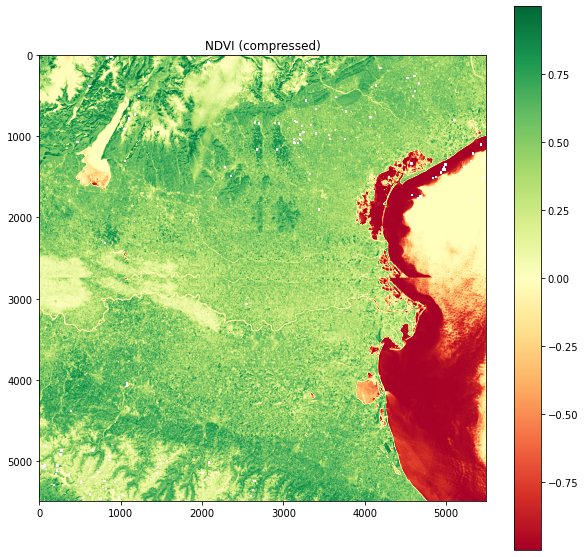

In [0]:
with rasterio.open(ndvi_mosaic_path) as src:
    ndvi_mosaic_data = src.read(1)

height, width = ndvi_mosaic_data.shape
# Reducing array dimension to enable visualization by applying an interpolation alghoritm 
reduced_ndvi_mosaic = resize(ndvi_mosaic_data, (height/4, width/4), anti_aliasing=True)

# Print new size 
print("Reduced array's size:", reduced_ndvi_mosaic.shape)

# Visualizing reduced image
plt.figure(figsize=(10, 10))
plt.imshow(reduced_ndvi_mosaic, cmap='RdYlGn')
plt.title('NDVI (compressed)')
plt.colorbar()
plt.show()

In [0]:
polygons_df = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/edoardo.albergo@studenti.unipd.it/vertici_final.csv")

display(polygons_df)

# Converting polygons_df to a Pandas df
polygons_df_pd = polygons_df.toPandas()

wkt_geom,fid,area_name,Area_km2,Count_N_stazioni_monitoraggio
"MultiPolygon (((788368.62910319317597896 5049177.66368059534579515, 765601.64333696849644184 5071991.12386245280504227, 784826.57915029185824096 5083438.60835820063948631, 785903.51892148214392364 5080746.25893022492527962, 807631.24631551362108439 5082553.68996792566031218, 808357.24584921856876463 5081911.86429320089519024, 809454.07183359120972455 5065169.81768951192498207, 788368.62910319317597896 5049177.66368059534579515)))",2,Marina,910.9,7
"MultiPolygon (((684791.54618068609852344 5056355.95990556757897139, 699601.32231544295791537 5078611.21050343569368124, 737437.93635774101130664 5067295.58761228062212467, 717812.40290589479263872 5046078.79469136614352465, 684791.54618068609852344 5056355.95990556757897139)))",3,Prealpina,955.7,9
"MultiPolygon (((672772.0671683584805578 4993687.90863255131989717, 674882.07426035800017416 5002020.12755217961966991, 678664.24938918207772076 5003774.11152270529419184, 726809.4155368332285434 5001742.14278762973845005, 730898.96655009023379534 4996873.52849599439650774, 731034.13317338260821998 4990921.12941916473209858, 713400.2311585204442963 4972606.26160767674446106, 696867.69403732649516314 4973944.14938556030392647, 687875.59617653070017695 4977373.08608494978398085, 682435.82445171859581023 4981797.43375446368008852, 674892.67432664555963129 4988252.62953457422554493, 672772.0671683584805578 4993687.90863255131989717)))",1,Pianura,1360.7,12


                                            wkt_geom fid  area_name Area_km2  \
0  MultiPolygon (((788368.62910319317597896 50491...   2     Marina    910.9   
1  MultiPolygon (((684791.54618068609852344 50563...   3  Prealpina    955.7   
2  MultiPolygon (((672772.0671683584805578 499368...   1    Pianura   1360.7   

  Count_N_stazioni_monitoraggio  \
0                             7   
1                             9   
2                            12   

                                            geometry  
0  MULTIPOLYGON (((788368.629 5049177.664, 765601...  
1  MULTIPOLYGON (((684791.546 5056355.960, 699601...  
2  MULTIPOLYGON (((672772.067 4993687.909, 674882...  


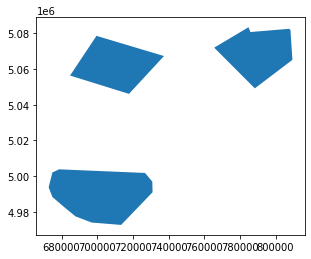

In [0]:
polygons_gdf = create_geodf_from_wkt(polygons_df_pd, crs_epsg=32632)

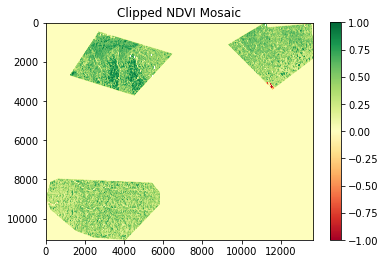

In [0]:
clipped_raster_path = 'ndvi_clipped.tif'
clip_raster_with_polygons(ndvi_mosaic_path, clipped_raster_path, polygons_gdf)